# Filtered navigable network - Step 1

This notebook test the way to create nodes and edges compatibles with OSMnx in order to be able to __use Santiago's public space quality index__ (Available in non-OSMnx road linestrings) __as a filter.__

The steps to be followed are the currently working QGIS steps:
1. Split lines with lines
2. Vector > Geometry Tools > Multipart to singleparts
3. Extract specific vertices [0,-1]
4. MMQGIS Modify > Drop dups

## Import libraries

In [80]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

from shapely.geometry import GeometryCollection
from shapely.ops import split
import time

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [2]:
gral_dir = '../../../data/external/santiago/'
project_name = 'redvial2019_buffer_3750m_c_utilidad_2'
p_code = '00'
public_space_quality_dir = gral_dir + f"calidad_ep/{p_code}_{project_name}/{project_name}.shp"

# Projection to be used whenever necessary
projected_crs = 'EPSG:32719'
# Column to filter data
filtering_column = 'pje_ep'
filtering_value = 0.5 # Will keep equal or more than this value

## Load data

In [3]:
# 1.0 --------------- LOAD DATA
# ------------------- This step loads the public space quality index gdf for the current project
# Load data
pub_space_qty = gpd.read_file(public_space_quality_dir)
# Set CRS
pub_space_qty = pub_space_qty.set_crs(projected_crs)
# Filter for data of relevance
gdf = pub_space_qty[[filtering_column,'geometry']].copy()
gdf = gdf.to_crs("EPSG:4326")

# Show
print(gdf.shape)
gdf.head(1)

(31534, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


## Step 1 - How to split lines with themselves?

In [92]:
# Tests - Isolate the first 10 lines
some_lines = gdf.loc[0:1999]

# Show
print(some_lines.shape)
some_lines.head(2)

(2000, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


<Axes: >

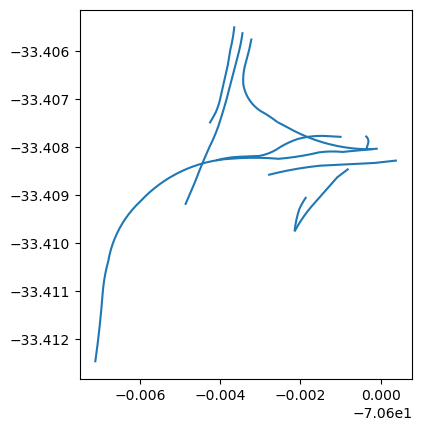

In [5]:
some_lines.plot()

### Split lines with themselves - __[Working, 10mins aprox.]__ Intersecting each line with the unary union of the rest of the lines using .apply()

Result: __FAIL__ - A los 960 segundos de intentar precompute_unary_union con todas las líneas se desconectó el Docker y Visual

In [6]:
from shapely.geometry import GeometryCollection
import time

#### __Part 1:__ precompute_unary_union function

##### __Part 1 Option A__ (Memory crashes with complete gdf, option B is faster and lighter)

* 2000 lines result: 41.16s, 144,144 bytes.
* Complete gdf result: Memory crash

In [30]:
def precompute_unary_union(gdf):
    
    # Reset index in order to keep track of original line id
    lines_gdf = gdf.copy()
    lines_gdf = lines_gdf.reset_index()
    lines_gdf = lines_gdf.rename(columns={'index':'original_id'})

    # Create unary union of all lines except itself
    lines_gdf['unary_geometry'] = None
    
    unary_sum_time = 0
    
    for idx, row in lines_gdf.iterrows():
        
        start = time.time()

        # Option A: rest_of_lines is all lines except itself
        rest_of_lines = lines_gdf.drop(idx).copy().explode()
        
        # Option B: rest_of_lines is lines that intersect line_of_interest (Remove itself to avoid trying to intersect with itself)
        #line_of_interest = lines_gdf.loc[lines_gdf.original_id==idx].copy()
        #intersecting_idxs = list(line_of_interest.sjoin(lines_gdf).original_id_right.unique())
        #intersecting_idxs.remove(idx)
        #rest_of_lines = lines_gdf.loc[lines_gdf.original_id.isin(intersecting_idxs)].copy().explode()

        # Save unary union
        lines_gdf.at[idx, 'unary_geometry'] = rest_of_lines.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        unary_sum_time = unary_sum_time + unary_extent

    print(unary_sum_time)
        
    return lines_gdf

option_a = precompute_unary_union(some_lines)

# Show
print(option_a.shape)
print(sys.getsizeof(option_a))
option_a

41.16363716125488
(2000, 4)
144144


,original_id,pje_ep,geometry,unary_geometry
0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",MULTILINESTRING ((-70.60035990020656 -33.40804...
1,1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
2,2,0.335099,"LINESTRING (-70.60215 -33.40975, -70.60207 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
3,3,0.106013,"LINESTRING (-70.60215 -33.40975, -70.60213 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
4,4,0.019630,"LINESTRING (-70.60426 -33.40751, -70.60418 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
...,...,...,...,...
1995,1995,0.398871,"LINESTRING (-70.71241 -33.47566, -70.71233 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
1996,1996,0.759022,"LINESTRING (-70.59714 -33.44613, -70.59707 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
1997,1997,0.542557,"LINESTRING (-70.61383 -33.44717, -70.61389 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
1998,1998,0.882666,"LINESTRING (-70.58764 -33.44384, -70.58863 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...


##### __Part 1 Option B__

* 2000 lines result: 29.17s, 114,672 bytes.
* Complete gdf result: 595.57s (9.92min), 2,268,720 bytes (2.27Mb)

In [96]:
def precompute_unary_union(gdf):
    
    # Reset index in order to keep track of original line id
    lines_gdf = gdf.copy()
    lines_gdf = lines_gdf.reset_index()
    lines_gdf = lines_gdf.rename(columns={'index':'original_id'})

    # Create unary union of all lines except itself
    lines_gdf['unary_geometry'] = None
    
    unary_sum_time = 0
    
    for idx, row in lines_gdf.iterrows():
        
        start = time.time()

        # Option A: rest_of_lines is all lines except itself
        #rest_of_lines = lines_gdf.drop(idx).copy().explode()
        
        # Option B: rest_of_lines is lines that intersect line_of_interest (Remove itself to avoid trying to intersect with itself)
        line_of_interest = lines_gdf.loc[lines_gdf.original_id==idx].copy()
        intersecting_idxs = list(line_of_interest.sjoin(lines_gdf).original_id_right.unique())
        intersecting_idxs.remove(idx)
        rest_of_lines = lines_gdf.loc[lines_gdf.original_id.isin(intersecting_idxs)].copy().explode()

        # Save unary union
        lines_gdf.at[idx, 'unary_geometry'] = rest_of_lines.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        unary_sum_time = unary_sum_time + unary_extent

    print(unary_sum_time)
        
    return lines_gdf

option_b = precompute_unary_union(gdf)

# Show
print(option_b.shape)
print(sys.getsizeof(option_b))
option_b

595.5722799301147
(31534, 4)
2268720


,original_id,pje_ep,geometry,unary_geometry
0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",MULTILINESTRING ((-70.60080319609531 -33.40845...
1,1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",MULTILINESTRING ((-70.60257531826466 -33.40748...
2,2,0.335099,"LINESTRING (-70.60215 -33.40975, -70.60207 -33...",MULTILINESTRING ((-70.60214554977048 -33.40975...
3,3,0.106013,"LINESTRING (-70.60215 -33.40975, -70.60213 -33...",MULTILINESTRING ((-70.60214554977048 -33.40975...
4,4,0.019630,"LINESTRING (-70.60426 -33.40751, -70.60418 -33...",LINESTRING (-70.60521540736343 -33.41106156503...
...,...,...,...,...
31529,31529,0.581119,"LINESTRING (-70.69190 -33.45897, -70.69192 -33...",MULTILINESTRING ((-70.69184989087246 -33.45915...
31530,31530,0.039703,"LINESTRING (-70.65000 -33.48546, -70.64996 -33...",LINESTRING (-70.65019616743754 -33.48615785809...
31531,31531,0.012621,"LINESTRING (-70.65020 -33.48616, -70.65018 -33...",LINESTRING (-70.64999927705391 -33.48546097838...
31532,31532,0.052166,"LINESTRING (-70.64985 -33.48548, -70.64968 -33...",None


#### __Part 2__

Input: Part 1 Option b

In [97]:
# Show
print(option_b.shape)
option_b.head(1)

(31534, 4)


,original_id,pje_ep,geometry,unary_geometry
0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",MULTILINESTRING ((-70.60080319609531 -33.40845...


In [98]:
lines_gdf = option_b.copy()
def split_line(row):
    line_geom = row['geometry']
    unary_geom = row['unary_geometry']
    
    try:
        split_result = split(line_geom, unary_geom)
        split_lines_geoms = list(split_result.geoms)
        return split_lines_geoms
    except:
        split_lines_geoms = [line_geom]
        return split_lines_geoms

# Apply the split operation using .apply()
lines_gdf['split_lines'] = lines_gdf.apply(split_line, axis=1)

# Explode the split lines into separate rows according to the list of geometries located in split_lines
exploded_split_lines = lines_gdf.explode('split_lines').drop(columns=['geometry']).rename(columns={'split_lines': 'geometry'})

# Create a new GeoDataFrame with the split lines
split_lines_gdf = gpd.GeoDataFrame(exploded_split_lines, geometry='geometry', crs=lines_gdf.crs)

# Drop unary_geometry col
split_lines_gdf.drop(columns=['unary_geometry'],inplace=True)

# Show
print(split_lines_gdf.shape)
split_lines_gdf.head(1)

(34790, 3)


,original_id,pje_ep,geometry
0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


### Split lines with themselves - __[Working, 10 mins aprox.]__ Intersecting each line with the unary union of the rest of the lines

#### __Option A:__ Unary union of all lines except line_of_interest

* 2000 lines result: 40.53s unary union, 4.00s saving split lines.
* Complete gdf result: Manually stopped after 1hr.

In [32]:
def split_lines_with_themselves(lines_gdf):
    split_lines = gpd.GeoDataFrame()
    i = 0
    
    # Reset index in order to keep track of original line id
    original_lines = lines_gdf.copy()
    original_lines = original_lines.reset_index()
    original_lines = original_lines.rename(columns={'index':'original_id'})

    unary_sum_time = 0
    split_sum_time = 0
    
    # Iterate over each line
    for idx in list(original_lines.original_id.unique()):
        start = time.time()
        
        # Find original line and its geometry
        line_of_interest = original_lines.loc[original_lines.original_id == idx]
        line_geom = line_of_interest.geometry.unique()[0]
        # Create unary union (geometry) out of the rest of the lines (Avoids trying to intersect with itself)
        rest_of_lines = original_lines.loc[original_lines.original_id != idx]
        gdf_exploded = rest_of_lines.copy().explode()
        unary_union = gdf_exploded.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        
        # Try splitting the line with the rest of the lines
        try:
            # Split geom with unary union
            split_result = split(line_geom, unary_union)
            # Extract clipped lines
            split_lines_geoms = list(split_result.geoms)
            # Register data
            for split_line_geom in split_lines_geoms:
                split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
                split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
                split_lines.loc[i,'geometry'] = split_line_geom
            
                i +=1
                
        # Except it doesn't need splitting, then just append the line
        except:
            split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
            split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
            split_lines.loc[i,'geometry'] = line_geom
            i +=1

        split_time = time.time()
        split_extent = split_time - unary_time

        unary_sum_time = unary_sum_time + unary_extent
        split_sum_time = split_sum_time + split_extent
            
        #print(f"unary_time {idx}: {unary_time - start}")
        #print(f"split_time {idx}: {split_time - unary_time}")
        
    print(f"unary_time {unary_sum_time}")
    print(f"split_time {split_sum_time}")
    
    try:
        split_lines.set_crs("EPSG:4326")
    except:
        split_lines.to_crs("EPSG:4326")
    
    return split_lines

In [88]:
# split_lines_with_themselves time test
split_lines = split_lines_with_themselves(some_lines)

# Show
print(split_lines.shape)
split_lines.head(2)

unary_time 0.06010150909423828
split_time 0.02144789695739746
(15, 3)


,original_id,pje_ep,geometry
0,0.0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,1.0,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


In [89]:
split_lines

,original_id,pje_ep,geometry
0,0.0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,1.0,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."
2,2.0,0.335099,"LINESTRING (-70.60215 -33.40975, -70.60207 -33..."
3,3.0,0.106013,"LINESTRING (-70.60215 -33.40975, -70.60213 -33..."
4,4.0,0.019630,"LINESTRING (-70.60426 -33.40751, -70.60418 -33..."
5,5.0,0.010179,"LINESTRING (-70.60344 -33.40561, -70.60346 -33..."
6,5.0,0.010179,"LINESTRING (-70.60444 -33.40834, -70.60452 -33..."
7,6.0,0.549756,"LINESTRING (-70.60322 -33.40575, -70.60328 -33..."
8,7.0,0.981766,"LINESTRING (-70.60410 -33.40828, -70.60396 -33..."
9,7.0,0.981766,"LINESTRING (-70.60183 -33.40779, -70.60181 -33..."


#### __Option B:__ Unary union of lines intersect line_of_interest only

* 2000 lines result: 27.83s unary union, 2.05s saving split lines.
* Full gdf result: 549.47s (9.16min) unary union, 63.68s saving split lines.

In [34]:
def split_lines_with_themselves_v2(lines_gdf):
    split_lines = gpd.GeoDataFrame()
    i = 0
    
    # Reset index in order to keep track of original line id
    original_lines = lines_gdf.copy()
    original_lines = original_lines.reset_index()
    original_lines = original_lines.rename(columns={'index':'original_id'})

    unary_sum_time = 0
    split_sum_time = 0
    
    # Iterate over each line
    for idx in list(original_lines.original_id.unique()):
        start = time.time()
        
        # Find original line and its geometry
        line_of_interest = original_lines.loc[original_lines.original_id == idx]
        line_geom = line_of_interest.geometry.unique()[0]

        # Find which lines intersect line of interest (Remove itself to avoid trying to intersect with itself)
        intersecting_idxs = list(line_of_interest.sjoin(original_lines).original_id_right.unique())
        intersecting_idxs.remove(idx)
        rest_of_lines = original_lines.loc[original_lines.original_id.isin(intersecting_idxs)].copy()
        
        # Create unary union (geometry) out of the rest of the lines 
        gdf_exploded = rest_of_lines.copy().explode()
        unary_union = gdf_exploded.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        
        # Try splitting the line with the rest of the lines
        try:
            # Split geom with unary union
            split_result = split(line_geom, unary_union)
            # Extract clipped lines
            split_lines_geoms = list(split_result.geoms)
            # Register data
            for split_line_geom in split_lines_geoms:
                split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
                split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
                split_lines.loc[i,'geometry'] = split_line_geom
            
                i +=1
                
        # Except it doesn't need splitting, then just append the line
        except:
            split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
            split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
            split_lines.loc[i,'geometry'] = line_geom
            i +=1

        split_time = time.time()
        split_extent = split_time - unary_time

        unary_sum_time = unary_sum_time + unary_extent
        split_sum_time = split_sum_time + split_extent
        
    print(f"unary_time {unary_sum_time}")
    print(f"split_time {split_sum_time}")
    
    try:
        split_lines.set_crs("EPSG:4326")
    except:
        split_lines.to_crs("EPSG:4326")
    
    return split_lines

In [37]:
# split_lines_with_themselves_v2 time test
split_lines = split_lines_with_themselves_v2(gdf)

# Show
print(split_lines.shape)
split_lines.head(2)

unary_time 549.4746608734131
split_time 63.688814878463745
(31534, 3)


,original_id,pje_ep,geometry
0,0.0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,1.0,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


In [12]:
# Check result in QGIS
#some_lines.to_file(gral_dir + "some_lines.gpkg", driver='GPKG')
#split_lines.to_file(gral_dir + "split_lines.gpkg", driver='GPKG')

### Split lines with themselves - __[NOT WORKING]__ Sjoining each line with the rest to identify which lines cross with with that line.

In [94]:
def split_lines_with_themselves(lines_gdf):

    original_lines = lines_gdf.copy()
    original_lines.reset_index(inplace=True)
    original_lines = original_lines.rename(columns={'index':'original_id'})

    idx_lst = [0,1,2,3,4,5,6,7,8] #list(original_lines.original_id.unique())

    # Find which lines intersect with which lines
    sjoined = original_lines.sjoin(original_lines)
    
    split_lines_list = []
    for idx in idx_lst:
        # Locate line of interest
        line_of_interest = original_lines.loc[original_lines.original_id==idx]
        # Locate which lines intersect that line of interest (Drop itself)
        sjoined_line = sjoined.loc[sjoined.original_id_left==idx]
        intersecting_lines_ids = list(sjoined_line.original_id_right.unique())
        intersecting_lines_ids.remove(idx)
        intersecting_lines = original_lines.loc[original_lines.original_id.isin(intersecting_lines_ids)]

        # Geometry of line of interest
        line_to_split = line_of_interest.geometry
        # Iterate over each intersecting lines geometry
        for splitter in intersecting_lines.geometry:
        
    return line_of_interest, intersecting_lines

line_of_interest, intersecting_lines = split_lines_with_themselves(some_lines)

### Split lines with themselves - __[NOT WORKING]__ Stack overflow Help

In [28]:
# SOURCE: https://gis.stackexchange.com/questions/447677/geopandas-split-intersecting-linestrings-and-keep-columns

In [7]:
# Show clipped (10 lines) data
print(some_lines.shape)
some_lines.head(2)

(10, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


#### Original Stack overflow code

In [19]:
# split ways
unary = some_lines.geometry.unary_union
geometries = [i for i in unary]
ids = [j for j in range(len(geometries))]
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], some_lines, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

# Show
print(joined.shape)
joined.head(1)

TypeError: 'MultiLineString' object is not iterable

#### Exploding before iterating

In [20]:
gdf_exploded = some_lines.copy().explode()
gdf_exploded.geom_type.unique()

array(['LineString'], dtype=object)

In [21]:
# split ways
unary = gdf_exploded.geometry.unary_union
geometries = [i for i in unary]
ids = [j for j in range(len(geometries))]
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], gdf_exploded, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

# Show
print(joined.shape)
joined.head(1)

TypeError: 'MultiLineString' object is not iterable

#### Adding .geoms to original stack overflow code

In [25]:
# split ways
unary = some_lines.geometry.unary_union
geometries = [i for i in unary.geoms]
ids = [j for j in range(len(geometries))]
print(len(ids))
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], some_lines, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

# Show
print(joined.shape)
joined

15
(7, 4)


,id,geometry,index_right,pje_ep
0,0,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",0,0.209171
1,1,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",1,0.273895
2,2,"LINESTRING (-70.60215 -33.40975, -70.60207 -33...",2,0.335099
3,3,"LINESTRING (-70.60215 -33.40975, -70.60213 -33...",3,0.106013
4,4,"LINESTRING (-70.60426 -33.40751, -70.60418 -33...",4,0.019630
7,7,"LINESTRING (-70.60322 -33.40575, -70.60328 -33...",6,0.549756
12,12,"LINESTRING (-70.60036 -33.40805, -70.60022 -33...",8,0.282520


<Axes: >

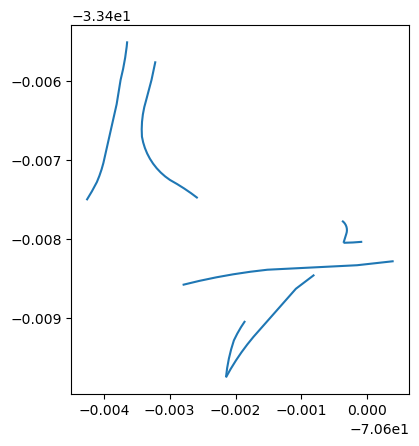

In [26]:
joined.plot()

### Split lines with themselves - __[NOT WORKING]__ ChatGPT suggested splitting each line with another line (splitter, except itself)

In [113]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import split

In [15]:
def split_lines_with_themselves(lines_gdf):
    # Ensure geometries are valid
    lines_gdf = lines_gdf[lines_gdf.is_valid]

    split_lines_list = []

    for idx, line in lines_gdf.iterrows():
        line_to_split = line.geometry  # Initialize the line to be split
        for splitter in lines_gdf.geometry:
            if line_to_split != splitter:  # Avoid splitting a line with itself
                try:
                    # Perform the split
                    split_result = split(line_to_split, splitter)
                    # Ensure that split_result has elements
                    if split_result:
                        split_line = MultiLineString([geom for geom in split_result])
                        
                        # Append the resulting split lines to the list inside the loop
                        if isinstance(split_line, MultiLineString):
                            split_lines_list.extend(split_line.geoms)  # Use .geoms to iterate over the LineStrings in the MultiLineString
                        else:
                            split_lines_list.append(split_line)
                except:
                    continue
    
    # Create a new GeoDataFrame with the split lines
    split_lines_gdf = gpd.GeoDataFrame(geometry=split_lines_list, crs=lines_gdf.crs)
    
    return split_lines_gdf

# Perform split_lines_with_themselves
#lines_gdf = gdf.copy()
#split_lines_gdf = split_lines_with_themselves(lines_gdf)

# Show
#print(split_lines_gdf.shape)
#split_lines_gdf.head(1)